In [66]:
import os
import time
import numpy as np
import pandas as pd
from typing import List
from surprise import (
    accuracy,
    Reader,
    Dataset,
    CoClustering,
    KNNBasic,
    NMF,
    SVD,
    SlopeOne,
    NormalPredictor
)
from surprise.model_selection.split import ShuffleSplit
from surprise.trainset import Trainset
import networkx as nx
import cdlib.algorithms as cd_alg
import karateclub as kc
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [67]:
def communitarian_recommendation_graph(
        n_user=100,
        n_comm=10,
        n_item=100,
        n_cat=10,
        like_prob=.4,
        like_strength=.5,
        debug=False,
    ):

    user_comm_gt = np.random.choice(n_comm, n_user)
    user_comm_gt.sort()
    bincount_user = np.bincount(user_comm_gt, minlength=n_comm)

    if debug:
        display('user', user_comm_gt, bincount_user)

    item_cat_gt = np.random.choice(n_cat, n_item)
    item_cat_gt.sort()
    bincount_item = np.bincount(item_cat_gt, minlength=n_cat)

    if debug:
        display('item', item_cat_gt, bincount_item)

    L = np.random.choice(2, (n_comm, n_cat), p=[1-like_prob, like_prob])

    L_prime = like_strength * L + (1-like_strength)/2

    P = np.block([
        [ np.zeros((n_comm,n_comm)) , L_prime                 ],
        [ L_prime.T                 , np.zeros((n_cat,n_cat)) ]
    ])

    if debug:
        display('like', L, L_prime, P)

    sbg = nx.stochastic_block_model(
        np.hstack((bincount_user, bincount_item)),
        P
    )

    if debug:
        try:
            nx.draw_networkx(
                sbg,
                nx.bipartite_layout(sbg, nx.bipartite.sets(sbg)[0]),
                node_color=np.hstack((user_comm_gt, item_cat_gt))
            )
        except nx.AmbiguousSolution as e:
            print(e)            

        plt.show()

    for user, item, data in sbg.edges(data=True):
        data['weight'] = np.random.randint(1,4) + 2*L[user_comm_gt[user], item_cat_gt[item-n_user]]

    if debug:
        display(np.mean([w['weight'] for user, item, w in sbg.edges(data=True) if L[user_comm_gt[min(user, item)], item_cat_gt[max(user, item)-n_user]]]))
        display(np.mean([w['weight'] for user, item, w in sbg.edges(data=True) if not L[user_comm_gt[min(user, item)], item_cat_gt[max(user, item)-n_user]]]))
        
    return sbg, user_comm_gt, item_cat_gt


def wf(G, u, v):
    w = 0    
    for nbr in set(G[u]) & set(G[v]):
        w += (G[u][nbr]['weight'] - G[v][nbr]['weight']) ** 2
    return 1/(1 + w)


In [68]:
crg, user_comm_gt, item_cat_gt = communitarian_recommendation_graph(n_user=10,n_item=10, n_cat=5, n_comm=2, debug=False)
data = nx.to_pandas_edgelist(crg)
data

,source,target,weight
0,0,14,2
1,0,17,4
2,0,19,5
3,1,10,1
4,1,16,3
5,1,15,2
6,1,18,3
7,1,19,5
8,2,11,2
9,2,12,3


In [69]:
mapeamento_invertido = {v: chr(v + 55) for v in range(10, 20)}
data['target'] = data['target'].replace(mapeamento_invertido)
data['source'] = data['source']+1

data


,source,target,weight
0,1,E,2
1,1,H,4
2,1,J,5
3,2,A,1
4,2,G,3
5,2,F,2
6,2,I,3
7,2,J,5
8,3,B,2
9,3,C,3


In [70]:
crg = nx.from_pandas_edgelist(data, source='source', target='target', edge_attr='weight')

In [71]:
pos = nx.bipartite_layout(crg, list(set(data['source'])))

In [72]:
pos_right = {node: (x, y) for node, (x, y) in pos.items() if node in list(set(data['target']))}

# Ordena as posições dos nós da parte direita por rótulo
pos_right = {node: pos_right[node] for node in sorted(pos_right.keys())}

# Atualiza as posições no layout
pos.update(pos_right)

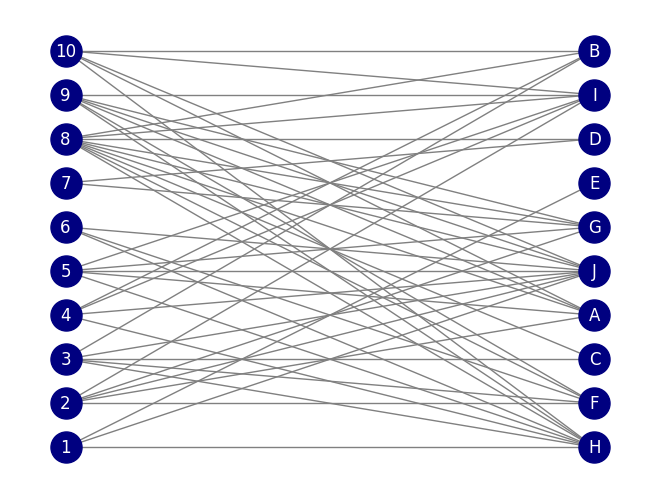

In [73]:
nx.draw(crg, pos, with_labels=True, node_color='navy', node_size=500, font_size=12, edge_color='gray', font_color='white')
#nx.draw(crg, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=12, edge_color='gray')
plt.axis('off')
plt.show()

In [74]:
g = nx.bipartite.generic_weighted_projected_graph(crg, 
                                                list(set(data['source'])), wf
                                                )

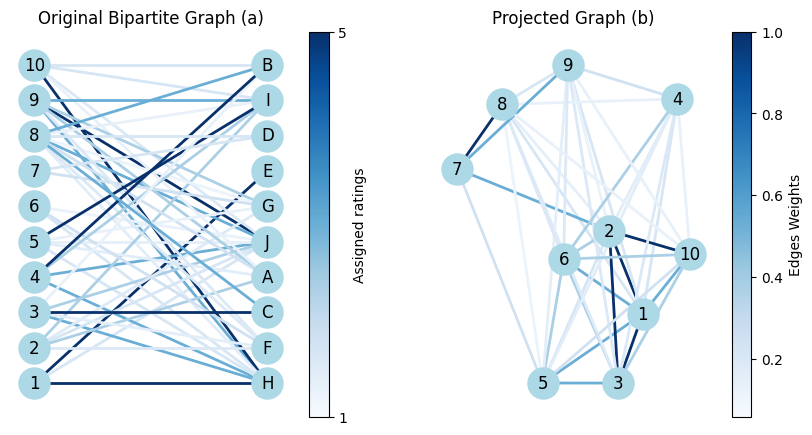

In [81]:
# Plot do grafo bipartido (crg)
pos = nx.bipartite_layout(crg, list(set(data['source'])))
pos_right = {node: (x, y) for node, (x, y) in pos.items() if node in list(set(data['target']))}
pos_right = {node: pos_right[node] for node in sorted(pos_right.keys())}
pos.update(pos_right)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Primeiro subplot para o grafo bipartido (crg)
ax1 = axes[0]
nx.draw(crg, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=12, edge_color=edge_colors, width=2.0, ax=ax1)
ax1.set_title('Original Bipartite Graph (a)')
ax1.axis('off')

# Plot do grafo unipartido (g)
pos = nx.spring_layout(g)
edges = g.edges()
weights_g = [g[u][v]['weight'] for u, v in edges]
edge_colors_g = plt.cm.Blues(np.array(weights_g))

# Segundo subplot para o grafo unipartido (g)
ax2 = axes[1]
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=12, edge_color=edge_colors_g, width=2.0, ax=ax2)
ax2.set_title('Projected Graph (b)')

# Adiciona a legenda das cores do grafo bipartido
sm1 = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=1, vmax=5))
sm1.set_array([1, 5])
cbar1 = plt.colorbar(sm1, ax=ax1, ticks=[1, 5])
cbar1.set_label('Assigned ratings')

# Adiciona a legenda das cores do grafo unipartido
sm2 = plt.cm.ScalarMappable(cmap=plt.cm.Blues)
sm2.set_array(weights_g)
cbar2 = plt.colorbar(sm2, ax=ax2)
cbar2.set_label('Edges Weights')

ax2.axis('off')

# Ajusta a posição dos subplots
plt.subplots_adjust(wspace=0.2)

# Exibe os subplots
plt.show()

In [82]:
g

In [87]:
coms.best_partition

AttributeError: 'list' object has no attribute 'best_partition'

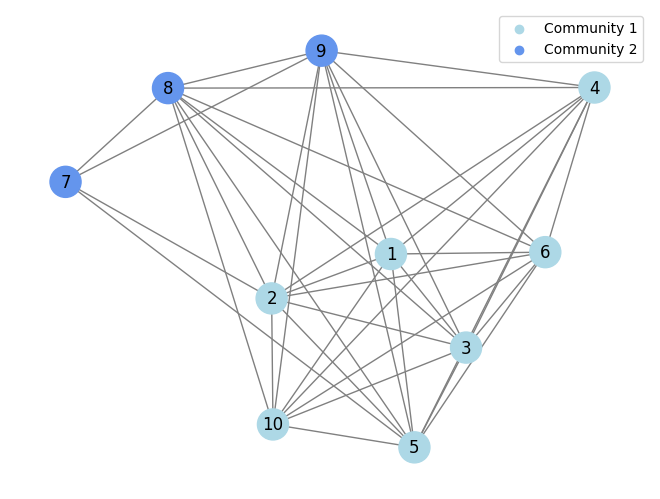

In [99]:
community_detector = nx.community.louvain_communities
coms = community_detector(g.copy())


# Criar um dicionário mapeando cada nó para sua respectiva comunidade
node_community_map = {}
for idx, com in enumerate(coms):
    for node in com:
        node_community_map[node] = idx

# Definir as cores para as comunidades
colors = ['lightblue', 'cornflowerblue', 'green', 'yellow', 'orange']  # Adicione mais cores se necessário

# Criar uma lista de cores para os nós, baseada nas comunidades identificadas
node_colors = [colors[node_community_map[node]] for node in g.nodes()]

# Plotar o grafo com as comunidades delimitadas por cores
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=12, edge_color='gray')

# Adicionar legenda das cores
for i, color in enumerate(colors[:len(coms)]):
    plt.scatter([], [], c=color, label=f'Community {i+1}')
plt.legend()

plt.show()


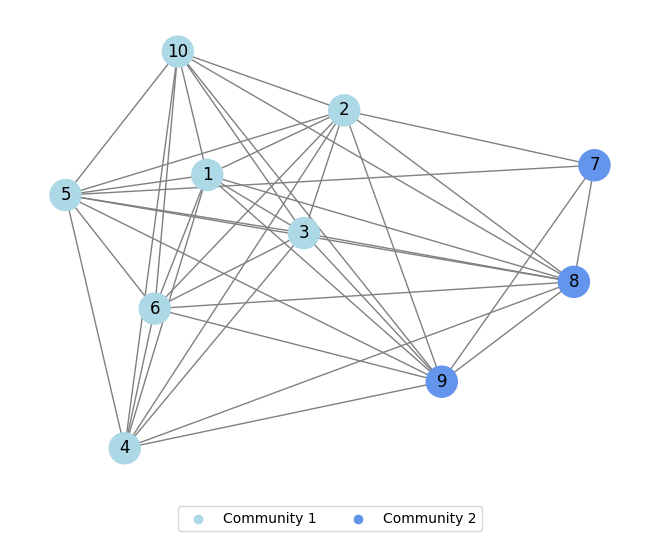

In [101]:
node_community_map = {}
for idx, com in enumerate(coms):
    for node in com:
        node_community_map[node] = idx

# Definir as cores para as comunidades
colors = ['lightblue', 'cornflowerblue', 'green', 'yellow', 'orange']  # Adicione mais cores se necessário

# Criar uma lista de cores para os nós, baseada nas comunidades identificadas
node_colors = [colors[node_community_map[node]] for node in g.nodes()]

# Plotar o grafo com as comunidades delimitadas por cores
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=12, edge_color='gray')

# Adicionar legenda das cores na parte de baixo
for i, color in enumerate(colors[:len(coms)]):
    plt.scatter([], [], c=color, label=f'Community {i+1}')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(coms))

# Definir a cor de fundo da área do gráfico
plt.gca().set_facecolor('lightgray')

plt.show()

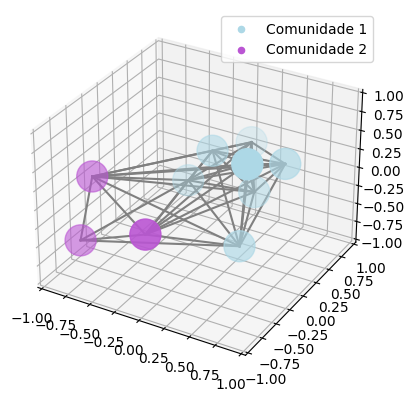

In [98]:
from mpl_toolkits.mplot3d import Axes3D

# community_detector = nx.community.louvain_communities  # Seu código original
# coms = community_detector(g.copy())  # Seu código original

# Supondo que você já possui as comunidades identificadas em "coms"

# Criar um dicionário mapeando cada nó para sua respectiva comunidade
node_community_map = {}
for idx, com in enumerate(coms):
    for node in com:
        node_community_map[node] = idx

# Definir as cores para as comunidades
colors = ['lightblue', 'mediumorchid', 'green', 'yellow', 'orange']  # Adicione mais cores se necessário

# Criar uma lista de cores para os nós, baseada nas comunidades identificadas
node_colors = [colors[node_community_map[node]] for node in g.nodes()]

# Criar figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Obter posições dos nós em 3D
pos_3d = nx.spring_layout(g, dim=3)

# Extrair as coordenadas x, y e z dos nós
node_x = [pos_3d[node][0] for node in g.nodes()]
node_y = [pos_3d[node][1] for node in g.nodes()]
node_z = [pos_3d[node][2] for node in g.nodes()]

# Plotar os nós em 3D
ax.scatter(node_x, node_y, node_z, c=node_colors, s=500)

# Plotar as arestas em 3D
for edge in g.edges():
    u, v = edge
    ax.plot([pos_3d[u][0], pos_3d[v][0]], [pos_3d[u][1], pos_3d[v][1]], [pos_3d[u][2], pos_3d[v][2]], color='gray')

# Definir limites dos eixos
ax.set_xlim3d([-1, 1])
ax.set_ylim3d([-1, 1])
ax.set_zlim3d([-1, 1])

# Adicionar legenda das cores
for i, color in enumerate(colors[:len(coms)]):
    ax.scatter([], [], [], c=color, label=f'Comunidade {i+1}')
plt.legend()

plt.show()

In [85]:
coms

[{7, 8, 9}, {1, 2, 3, 4, 5, 6, 10}]

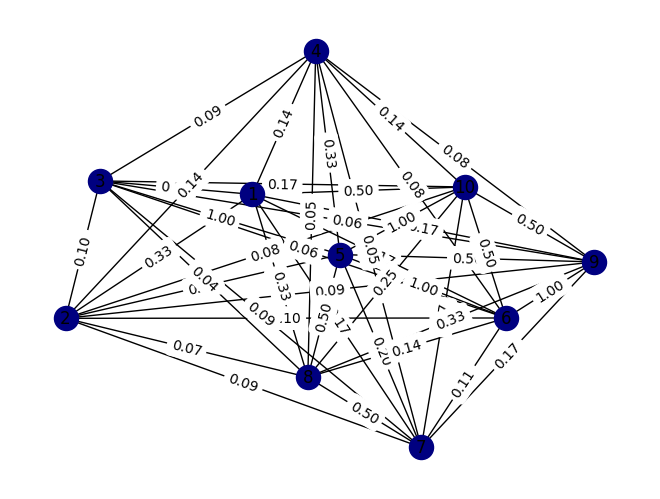

In [54]:
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True, node_color='navy')

# Obtém os pesos das arestas
edge_labels = {(u, v): f'{w:.2f}' for (u, v, w) in g.edges(data='weight')}

# Plota os rótulos das arestas com os pesos arredondados
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)

plt.show()

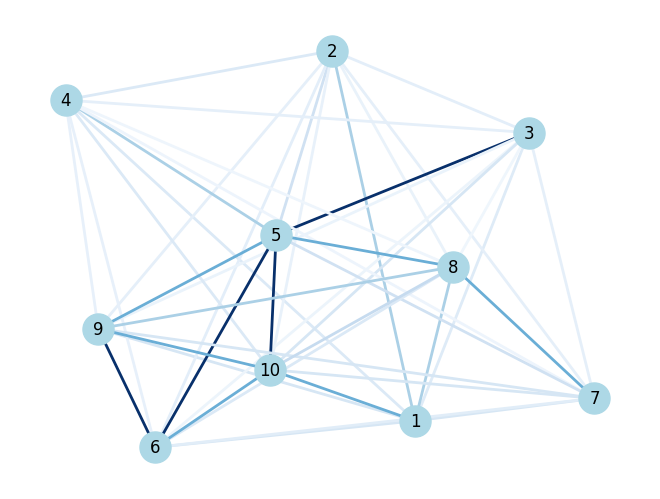

In [55]:
pos = nx.spring_layout(g)
edges = g.edges()
weights = [g[u][v]['weight'] for u, v in edges]

# Define a cor das arestas de acordo com os pesos
edge_colors = plt.cm.Blues(np.array(weights))

# Plota o grafo com as cores das arestas
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=12, edge_color=edge_colors, width=2.0)

plt.axis('off')
plt.show()

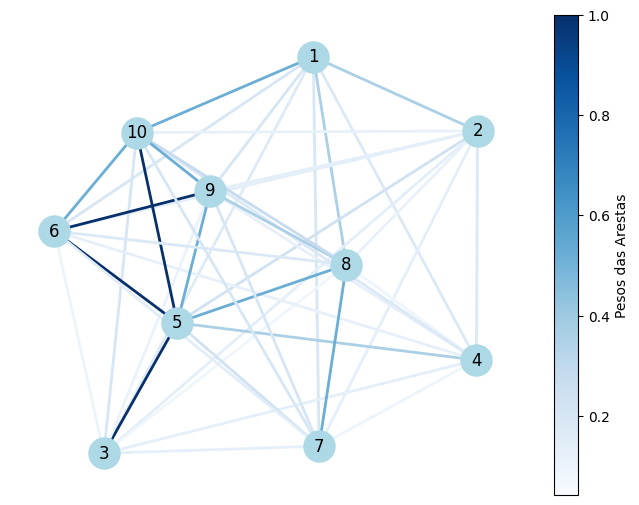

In [56]:
# Plota o grafo com as cores das arestas indicando os pesos
pos = nx.spring_layout(g)
edges = g.edges()
weights = [g[u][v]['weight'] for u, v in edges]

# Define a cor das arestas de acordo com os pesos
edge_colors = plt.cm.Blues(np.array(weights))

# Plota o grafo com as cores das arestas
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=12, edge_color=edge_colors, width=2.0)

# Adiciona a legenda das cores
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues)
sm.set_array(weights)
plt.colorbar(sm, label='Pesos das Arestas')

plt.axis('off')
plt.show()

